In [1]:
## CE 295 - Energy Systems and Control
# HW 2 : State Estimation in Oil Well Drilling
# Carlin Liao, SID 24358933
# Prof. Moura

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import interp
from scipy import signal
%matplotlib inline
from __future__ import division
import pandas as pd
import control # Read http://python-control.sourceforge.net/manual/

fs = 15 # Font Size for plots

# Drill String Parameters

J_T = 100  # Table/top rotational inertia
J_B = 25   # Bottom/bit rotational inertia
k = 2      # Spring constant
b = 5     # Drag coefficient

In [2]:
d = np.matrix([[1,2],[3,4]])
e = np.matrix([[1,2],[3,4]])

In [3]:
## Problem 2 - Observability Analysis

# State space matrices
A4 = np.matrix([[ 0, 0, 1, 0], [ 0, 0, 0, 1], [ -k/J_T, k/J_T, -b/J_T, 0], [ k/J_B, -k/J_B, 0, -b/J_B]])
B4 = np.matrix([[0,0], [0,0], [1/J_T, 0], [0, -1/J_B] ])
C4 = np.matrix([[1, 0, 1, 0]])

# Compute observability Matrix for 4-state system and rank
O4 = np.matrix([[1, 0, 1, 0], [-k/J_T, k/J_T, 1-b/J_T, 0], [(k/J_T)**2, (k/J_T)**2, 1+(b/J_T)**2, 0], [-(k/J_T)**3, (k/J_T)**3, 1-(b/J_T)**3, 0]])
print('Rank of Observability Matrix for four-state system')
print(np.linalg.matrix_rank(O4))

# New A Matrix, for 3-state system
A = np.matrix([[ 0, 1, -1], [ -k/J_T, -b/J_T, 0], [ k/J_B, 0, -b/J_B]])
B = np.matrix([[0,0], [1/J_T, 0], [0, -1/J_B] ])
C = np.matrix([[0, 1, 0]])

# Observability Matrix for 3-state system and rank
O = np.matrix([[0, 1, 0], [-k/J_T, -k/J_T, 0], [(k/J_T)**2, (k/J_T)**2, 0]])
print('Rank of Observability Matrix for three-state system')
print(np.linalg.matrix_rank(O))

Rank of Observability Matrix for four-state system
3
Rank of Observability Matrix for three-state system
2


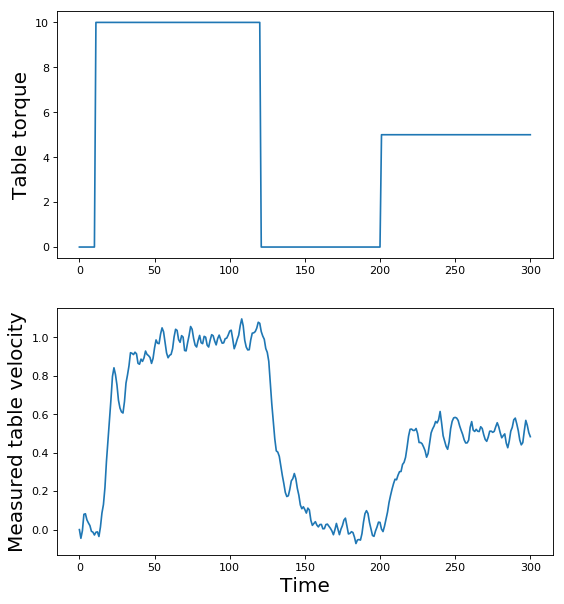

In [4]:
## Load Data
data=np.asarray(pd.read_csv("HW2_Data.csv",header=None))

t = data[:,0]      # t   : time vector [sec]
y_m = data[:,1]    # y_m : measured table velocity [radians/sec]
Torq = data[:,2]   # Torq: table torque [N-m]
omega_B_true = data[:,3]    # \omega_B : true rotational speed of bit [radians/sec]

# Plot Data
plt.figure(num=1, figsize=(8, 9), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
plt.plot(t,Torq)
plt.ylabel('Table torque',fontsize=18)
# Plot table torque

plt.subplot(2,1,2)
plt.plot(t,omega_B_true)
plt.ylabel('Measured table velocity',fontsize=18)
# Plot measured table velocity

plt.xlabel('Time', fontsize=18)
plt.show()

In [5]:
## Problem 4 - Luenberger Observer

# Eigenvalues of open-loop system
print('Eigenvalues of open-loop system:')
lam_A,evec = np.linalg.eig(A)
print(lam_A)

Eigenvalues of open-loop system:
[-0.08338525+0.29860789j -0.08338525-0.29860789j -0.08322949+0.j        ]


In [6]:
# Desired egnvals of estimation error system
#   They should have negative real parts
#   Complex conjugate pairs
lam_luen = 5*np.array([-0.08338525+0.29860789j, -0.08338525-0.29860789j, -0.08322949+0.j ])

# Compute observer gain (See Remark 3.1 in Notes. Use "acker" command)
L = np.matrix(control.acker(A.T, C.T, lam_luen).T)

test, _ = np.linalg.eig(A-L*C)
test

array([-0.41692625+1.49303945j, -0.41692625-1.49303945j, -0.41614745+0.j        ])

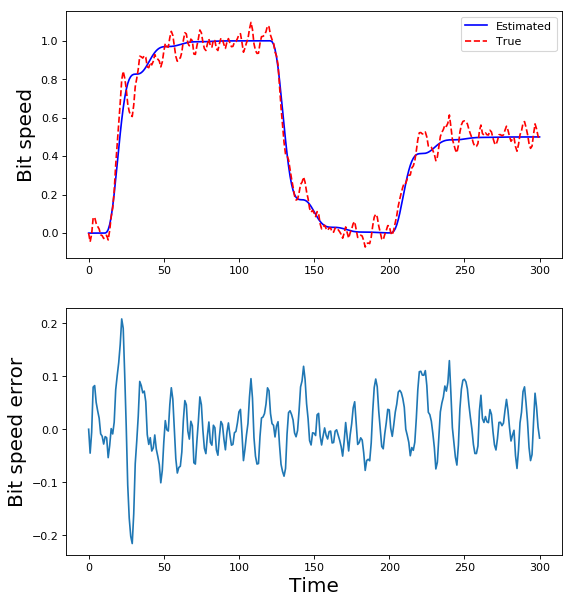

Total RMS Error: 0.055363910649410104


In [7]:
# State-space Matrices for Luenberger Observer
A_lobs = A
B_lobs = B[:,0]
C_lobs = C
D_lobs = 0

sys_lobs = signal.lti( A_lobs, B_lobs, C_lobs, D_lobs)

# Inputs to observer
u = Torq

# Initial Conditions
x_hat0 = [ 0, 0, 0]

# Simulate Response
tsim, y, x_hat = signal.lsim(sys_lobs, U=u, T=t, X0=x_hat0)

# Parse states
theta_hat = x_hat[:,0]
omega_T_hat = x_hat[:,1]
omega_B_hat = x_hat[:,2]

# Plot Results
plt.figure(num=1, figsize=(8, 9), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
# Plot true and estimated bit velocity
plt.plot(tsim, omega_B_hat, 'b', label='Estimated')
plt.plot(tsim, omega_B_true, 'r--', label='True')
plt.ylabel('Bit speed', fontsize=18)
plt.legend()

plt.subplot(2,1,2)
# Plot error between true and estimated bit velocity
# plt.plot(tsim, np.sqrt((omega_B_true - omega_B_hat)**2/(tsim[-1])))
# plt.plot(tsim, np.sqrt(np.cumsum((omega_B_true - omega_B_hat)**2)/(tsim[-1])))
plt.plot(tsim, (omega_B_true - omega_B_hat))
plt.ylabel('Bit speed error', fontsize=18)

plt.xlabel('Time', fontsize=18)
plt.show()

print('Total RMS Error: {}'.format(np.sqrt(np.sum((omega_B_true - omega_B_hat)**2)/(tsim[-1]))))

Kalman Filter RMSE: 0.0469337462244 rad/s


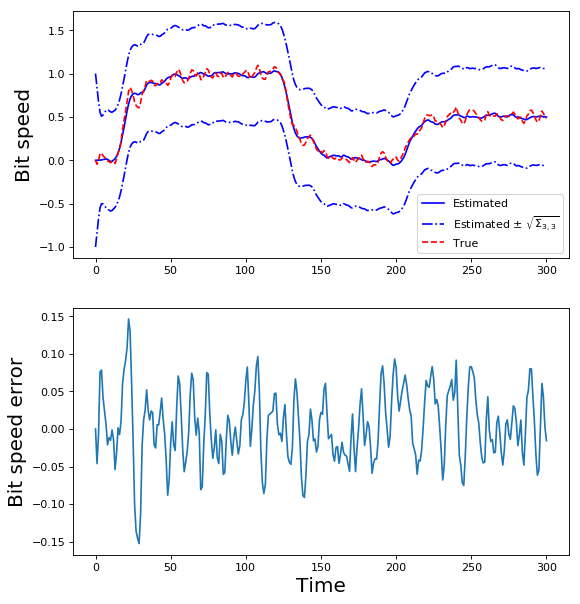

In [8]:
## Problem 5 - Kalman Filter
# Noise Covariances
W = np.diag([1, 0.01, 0.1]) #You design this one. 
N = 0.02
Sig0 = np.eye(3)

# Initial Condition
x_hat0 = [ 0, 0, 0 ]
states0 = np.r_[x_hat0, np.squeeze(np.asarray(Sig0.reshape(9,1)))]

# Ordinary Differential Equation for Kalman Filter
def ode_kf(z,it):
    
    # Parse States
    x_hat = np.matrix(z[:3]).T
    Sig = np.matrix((z[3:]).reshape(3,3))
    
    # Interpolate input signal data
    iTorq = interp(it, t, Torq)
    iy_m = interp(it, t, y_m)
    
    # Compute Kalman Gain
    L = Sig*C.T*N**-1
    
    # Kalman Filter
    x_hat_dot = A*x_hat + B[:,0]*iTorq + L*(iy_m - C*x_hat)
    
    # Riccati Equation
    Sig_dot = Sig*A.T + A*Sig + W - Sig*C.T*(N**-1)*C*Sig
    
    # Concatenate LHS
    z_dot = np.r_[x_hat_dot, Sig_dot.reshape(9,1)] # Sig33 is add the end of this array
    
    return(np.squeeze(np.asarray(z_dot)))


# Integrate Kalman Filter ODEs
z = odeint(ode_kf, states0, t)

# Parse States
theta_hat = z[:,0]
omega_T_hat = z[:,1]
omega_B_hat = z[:,2]
Sig33 = z[:,-1]     # Parse out the (3,3) element of Sigma only!

omega_B_tilde = omega_B_true - omega_B_hat
omega_B_hat_upperbound = omega_B_hat + np.sqrt(Sig33)
omega_B_hat_lowerbound = omega_B_hat - np.sqrt(Sig33)

RMSE = np.sqrt(np.mean(np.power(omega_B_tilde,2)))
print('Kalman Filter RMSE: ' + str(RMSE) + ' rad/s')


# Plot Results
plt.figure(num=3, figsize=(8, 9), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
#   Plot true and estimated bit velocity
#   Plot estimated bit velocity plus/minus one sigma
plt.plot(t, omega_B_hat + np.sqrt(Sig33), 'b-.')
plt.plot(t, omega_B_hat, 'b', label='Estimated')
plt.plot(t, omega_B_hat - np.sqrt(Sig33), 'b-.', label='Estimated $\pm\ \sqrt{\Sigma_{3,3}}$')
plt.plot(t, omega_B_true, 'r--', label='True')
plt.ylabel('Bit speed', fontsize=18)
plt.legend()

plt.subplot(2,1,2)
#   Plot error between true and estimated bit velocity
plt.plot(tsim, (omega_B_true - omega_B_hat))
plt.ylabel('Bit speed error', fontsize=18)

plt.xlabel('Time', fontsize=18)
plt.show()

In [9]:
sigma300 = z[-1,3:].reshape(3,3)
eval300, _ = np.linalg.eig(A - (sigma300*C.T*N**-1)*C)
print('KF t300 eigenvalues: {}'.format(eval300))
print('LO used eigenvalues: {}'.format(lam_luen))

KF t300 eigenvalues: [-0.18107734+0.28976716j -0.18107734-0.28976716j -0.66697227+0.j        ]
LO used eigenvalues: [-0.41692625+1.49303945j -0.41692625-1.49303945j -0.41614745+0.j        ]


Extended Kalman Filter RMSE: 0.0450165889712 rad/s


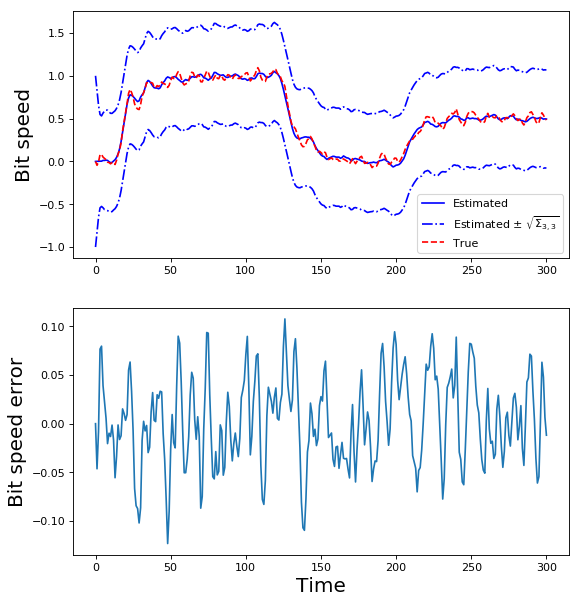

In [10]:
## Problem 6 - Extended Kalman Filter

# New nonlinear spring parameters
k1 = 2
k2 = 0.25

# Noise Covariances
W = W #You design this one. 
N = N
Sig0 = Sig0

# Initial Condition
x_hat0 = x_hat0
states0 = np.r_[x_hat0, np.squeeze(np.asarray(Sig0.reshape(9,1)))]

# Ordinary Differential Equation for Kalman Filter
def ode_ekf(z,it):
    
    # Parse States
    theta_hat = z[0]
    omega_T_hat = z[1]
    omega_B_hat = z[2]
    Sig = np.matrix((z[3:]).reshape(3,3))
    
    # Interpolate input signal data
    iTorq = interp(it, t, Torq)
    iy_m = interp(it, t, y_m)
    
    # Compute Jacobians
    F = np.matrix([[ 0, 1, -1], [ -k1/J_T, -b/J_T, 0], [ k1/J_B, 0, -b/J_B]]) + \
        np.matrix([[ 0, 0, 0], [ -3*k2/J_T, 0, 0], [ 3*k2/J_B, 0, 0]])# YOU DERIVE THESE
    H = C # YOU DERIVE THESE
    
    # Compute Kalman Gain
    L = Sig*H.T*N**-1
    
    # Compute EKF system matrices
    y_hat = omega_T_hat
    
    theta_hat_dot = omega_T_hat - omega_B_hat + L[0]*(iy_m - omega_T_hat)
    omega_T_hat_dot = -k1/J_T*theta_hat - b/J_T*omega_T_hat - k2/J_T*theta_hat**3 + iTorq/J_T + L[1]*(iy_m - omega_T_hat)
    omega_B_hat_dot = k1/J_B*theta_hat - b/J_B*omega_B_hat + k2/J_B*theta_hat**3 + L[2]*(iy_m - omega_T_hat)
    
    # Riccati Equation
    Sig_dot = Sig*F.T + F*Sig + W - Sig*H.T*(N**-1)*H*Sig
    
    # Concatenate LHS
    z_dot = np.r_[theta_hat_dot, omega_T_hat_dot, omega_B_hat_dot, Sig_dot.reshape(9,1)]
    
#     print(theta_hat_dot.shape)
#     print(omega_T_hat_dot.shape)
#     print(omega_B_hat_dot.shape)
#     print(z_dot.shape)
    
    return(np.squeeze(np.asarray(z_dot)))


# Integrate Extended Kalman Filter ODEs
z = odeint(ode_ekf, states0, t)

# Parse States
theta_hat = z[:,0]
omega_T_hat = z[:,1]
omega_B_hat = z[:,2]
Sig33 = z[:,-1]

omega_B_tilde = omega_B_true - omega_B_hat
omega_B_hat_upperbound = omega_B_hat + np.sqrt(Sig33)
omega_B_hat_lowerbound = omega_B_hat - np.sqrt(Sig33)

RMSE = np.sqrt(np.mean(np.power(omega_B_tilde,2)))
print('Extended Kalman Filter RMSE: ' + str(RMSE) + ' rad/s')


# Plot Results
plt.figure(num=3, figsize=(8, 9), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
#   Plot true and estimated bit velocity
#   Plot estimated bit velocity plus/minus one sigma
plt.plot(t, omega_B_hat + np.sqrt(Sig33), 'b-.')
plt.plot(t, omega_B_hat, 'b', label='Estimated')
plt.plot(t, omega_B_hat - np.sqrt(Sig33), 'b-.', label='Estimated $\pm\ \sqrt{\Sigma_{3,3}}$')
plt.plot(t, omega_B_true, 'r--', label='True')
plt.ylabel('Bit speed', fontsize=18)
plt.legend()

plt.subplot(2,1,2)
#   Plot error between true and estimated bit velocity
plt.plot(tsim, (omega_B_true - omega_B_hat))
plt.ylabel('Bit speed error', fontsize=18)

plt.xlabel('Time', fontsize=18)
plt.show()